# Stage I

1) сгенерить waveform синуса,  с напр., 10k отсчетов (на один период) (1 Hz)

2) нарисовать его, нарисовать fft, и попробовать правильно подписать оси и деления шкал на них ;)

3) сымитировать оцифровку -- понизить чсило отсчетов например а) до 500, и до 25 — и повторить п.2, при этом увидеть какие искажения в спектре возникли

4) сымитировать "кривую" оцифровку -- при уменьшении частоты дескритезации брать отсчеты с разным смещением в лево и вправо,
(аналог физовых искажений, jitter), и снова посмотреть 2) на 5-10% периода

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, rfft
from typing import Tuple
import random
import math

%matplotlib inline

In [3]:
def sin_tick(sampling_rate: int, period: int = 1) -> Tuple[np.array, np.array]:
    x = np.linspace(0, 1 * int(period), sampling_rate, endpoint=True)
    y = np.sin(2 * np.pi * x)
    return x, y
def rand_sigh():
    return -1 if random.random() > 0.5 else 1.0

In [4]:
def sin_tick_rand_jitter(sampling_rate: int, period: int, jitter_tick_max_percent: float = 0.0, jitter_magnitude_max_percent: float = 0.0) -> Tuple[np.array, np.array]:
    random.seed(1112220)
    x = []
    size = 0.
    jit_tick = (float(jitter_tick_max_percent) / 100.)
    jit_mag = (float(jitter_magnitude_max_percent) / 100.)
    for i, ix in enumerate(np.linspace(0, period, sampling_rate, endpoint=True)):
        if i in {0, sampling_rate}:
            x.append(float(ix))
            continue
        xf = float(ix)
        if size == 0.:
            size = xf
        xf = xf + size * jit_tick * rand_sigh()
        x.append(xf)
    random.seed(3312220)
    y = []
    for ix in x:
        yi = 1 * math.sin(2 * math.pi * ix)
        yi = yi + yi * jit_mag * rand_sigh()
        y.append(yi)
    return np.array(x), np.array(y)

# FFT

[scipy.fftpack](https://docs.scipy.org/doc/scipy/reference/fftpack.html)

`fft(x, n)` - Return discrete Fourier transform of real or complex sequence.

`fftshift(x)` - Shift the zero-frequency component to the center of the spectrum.

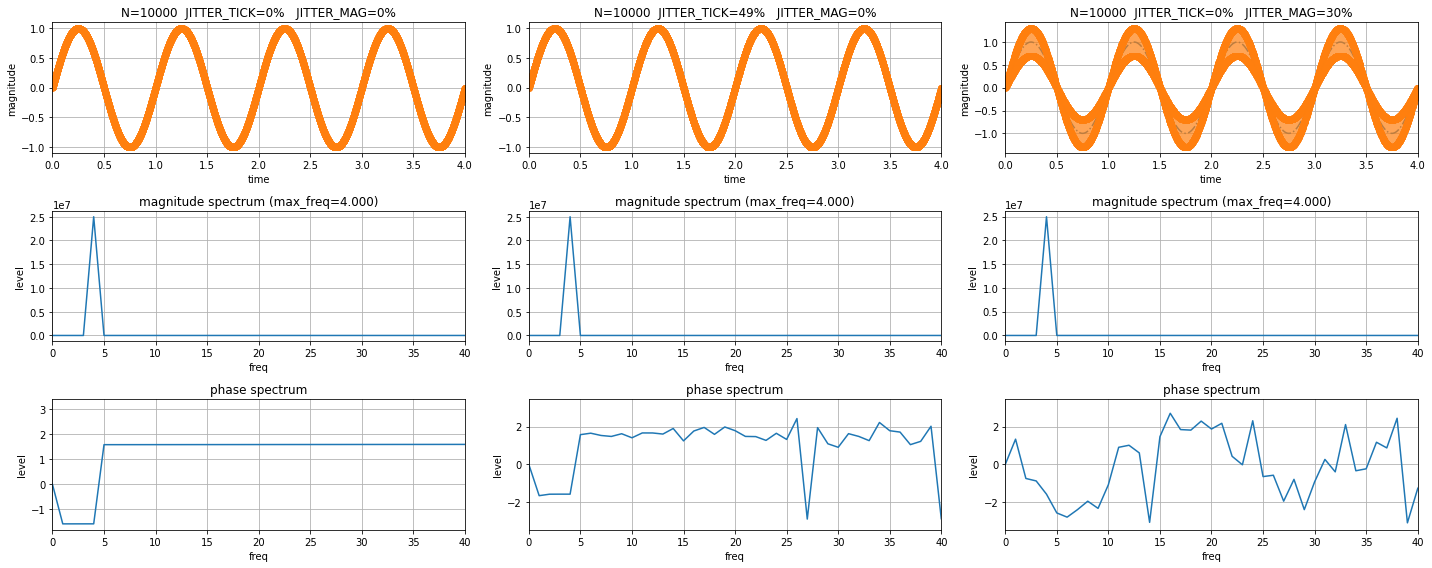

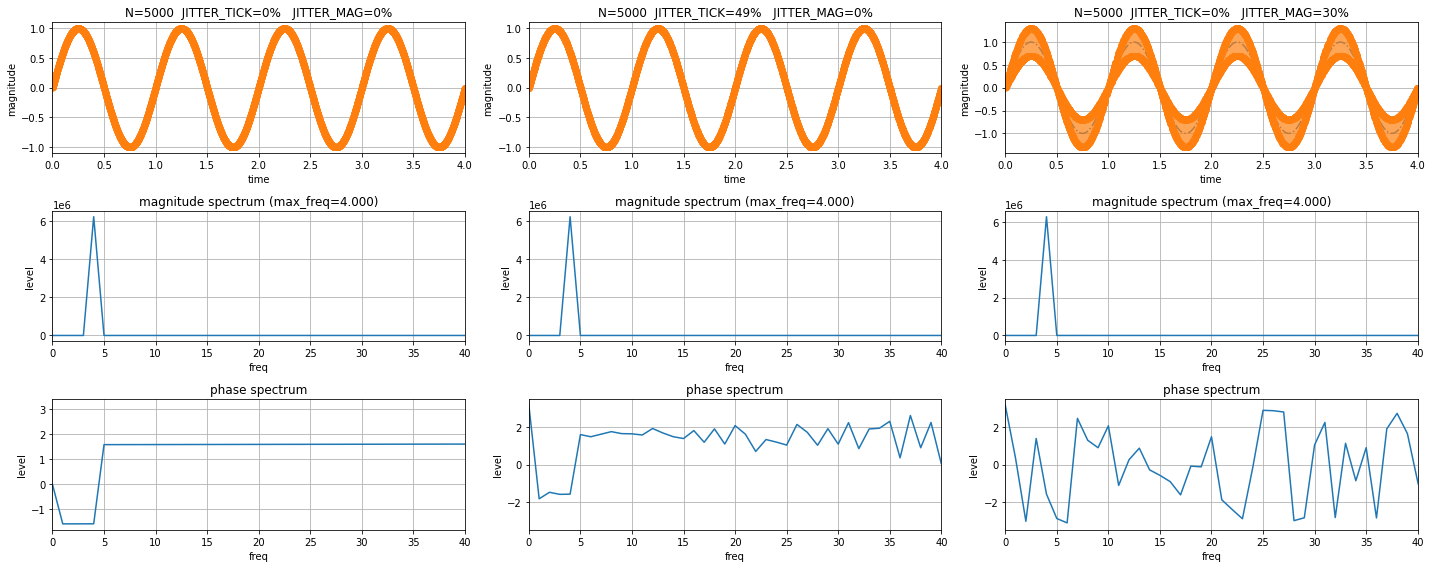

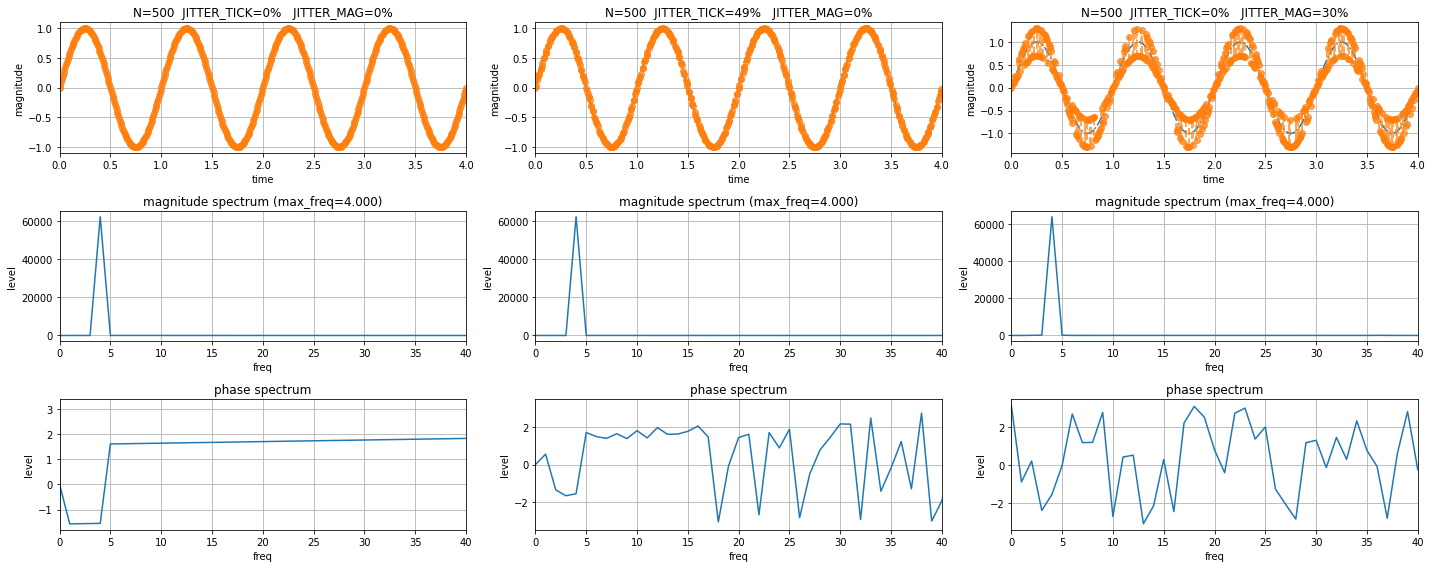

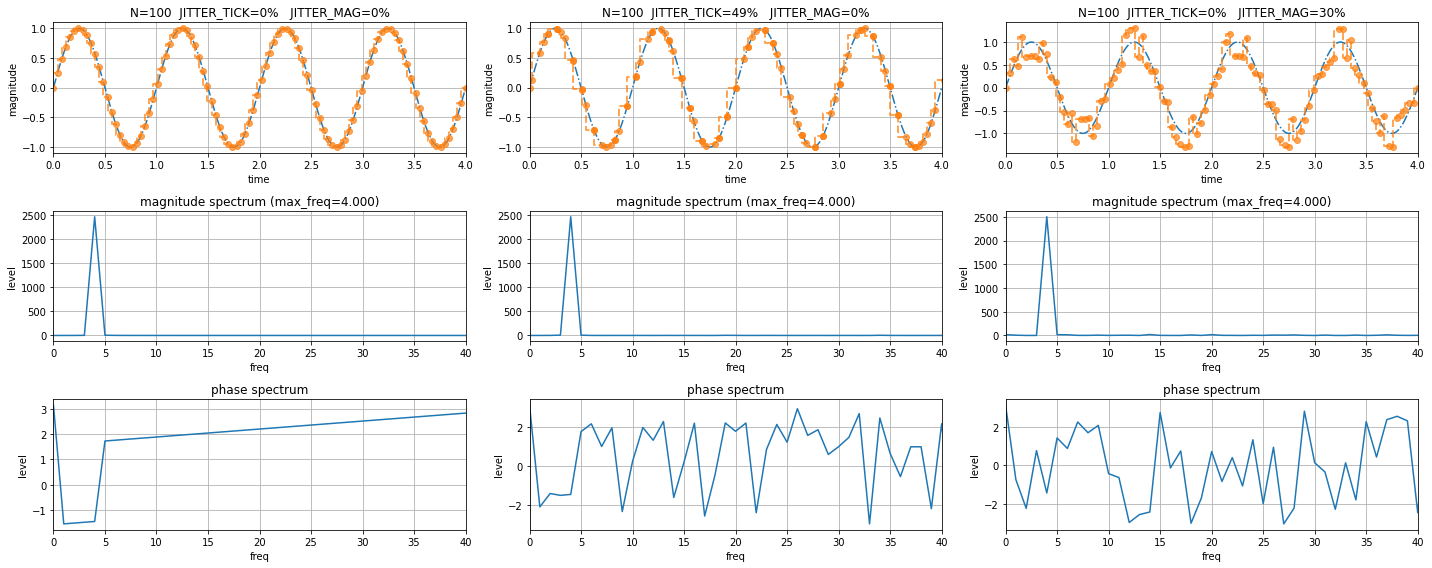

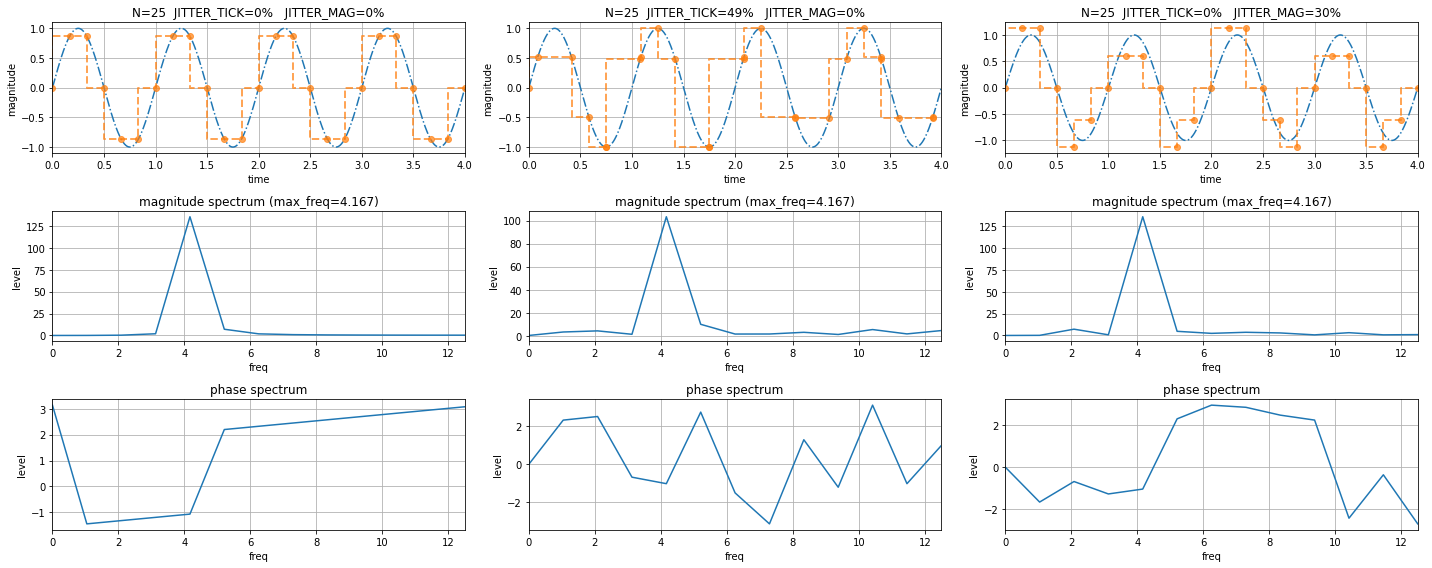

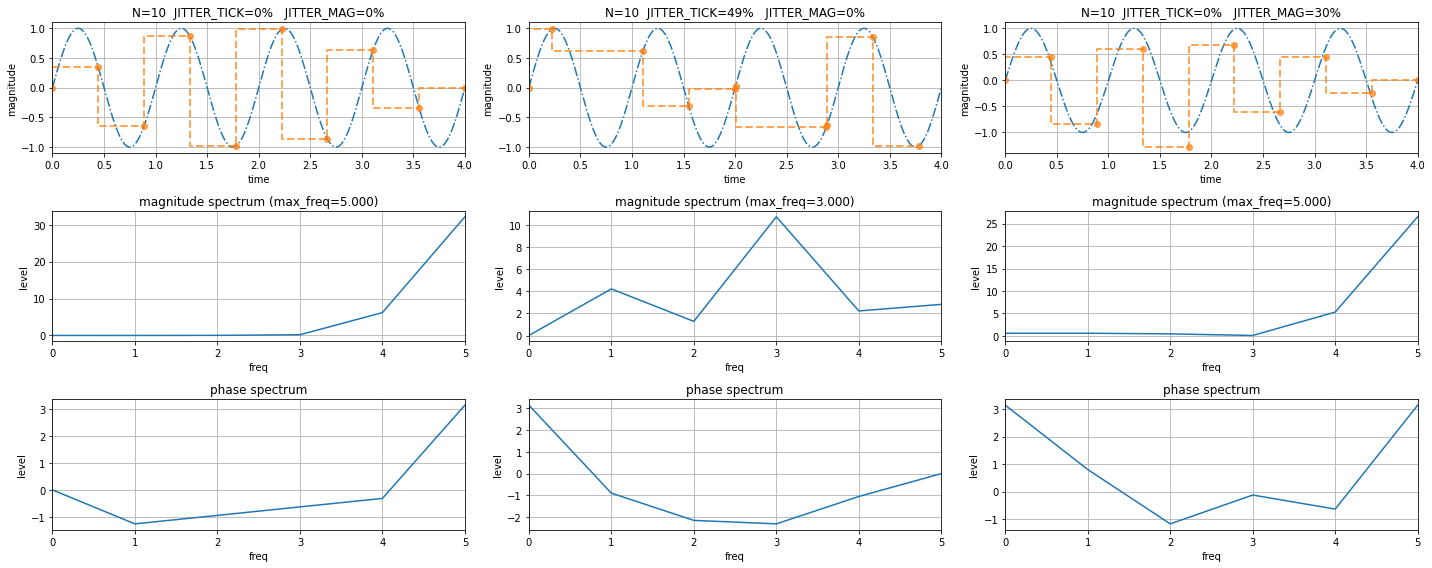

In [7]:
SIN_FREQ = 4

ideal_x, ideal_y = sin_tick(10000, SIN_FREQ)

N_FFT = 2048

for i, (sampling_rate, jit_tick, jit_amp) in enumerate((
    (10000, 49, 30),
    (5000, 49, 30),
    (500, 49, 30),
    (100, 49, 30),
    (25, 49, 30),
    (10, 49, 30),
)):
    fig = plt.figure(figsize=(20, 8))
    variants = (
        (0, 0),
        (jit_tick, 0),
        (0, jit_amp),
#         (jit_tick, jit_amp),
    )
    for i, (jit_tick, jit_amp) in enumerate(variants):
        plt.subplot(3, len(variants), i + 1)
        plt.plot(ideal_x, ideal_y, '-.')
        plt.xlim((ideal_x[0], ideal_x[-1]))
        plt.grid()
        plt.title(f'N={sampling_rate}  JITTER_TICK={jit_tick}%   JITTER_MAG={jit_amp}%')

        x, y = sin_tick_rand_jitter(sampling_rate, SIN_FREQ, jit_tick, jit_amp)
        plt.step(x, y, '--o', linewidth=2.0, alpha=0.7)
        plt.xlabel("time")
        plt.ylabel("magnitude")

        y_fft = np.fft.rfft(y, len(y))
        magnitude_spectrum = np.square(np.abs(y_fft))
        # The power spectrum is calculated as the square of
        # the absolute value of the discrete Fourier transform
        # https://www.kite.com/python/answers/how-to-plot-a-power-spectrum-in-python

        freq = np.linspace(0, sampling_rate/2, len(magnitude_spectrum))

        df = pd.DataFrame({"magnitude_level": magnitude_spectrum, "freq": freq})

        max_freq = df.iloc[df['magnitude_level'].idxmax()]['freq']

        # spectrum
        plt.subplot(3, len(variants), i + 1 + len(variants))
        plt.grid()
        plt.title(f'magnitude spectrum (max_freq={max_freq:0.3f})')
        plt.xlabel("freq")
        plt.ylabel("level")
        plt.xlim([freq[0], min(max_freq * 10, freq[-1])])
        plt.plot(freq, magnitude_spectrum)

        # phase
        phase_spectrum = np.angle(y_fft)
        plt.subplot(3, len(variants), i + 1 + 2 * len(variants))
        plt.grid()
        plt.title('phase spectrum')
        plt.xlabel("freq")
        plt.ylabel("level")
        plt.xlim([freq[0], min(max_freq * 10, freq[-1])])
        plt.plot(freq, phase_spectrum)

    plt.tight_layout()
    plt.show()
